Hi! Let's start with importing libraries, making it easier to write SQL queries:

In [115]:
from creds import creds
import pandas as pd
pd.options.plotting.backend = "plotly"
import pandas.io.sql as sqlio
import geopandas as gpd
import plotly.express as px
import psycopg2
from IPython.display import display

conn = psycopg2.connect(
    host=creds['host'],
    database=creds['dbname'],
    user=creds['user'],
    password=creds['password']
)

def exec_sql_query(q):
    return sqlio.read_sql_query(q, conn)



In [116]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [117]:
usa_states = gpd.read_file('USA_States/USA_States.shp')

def usa_map(
        data,
        color_column,
        color_continuous_scale="Viridis",
        color_continuous_midpoint=None
    ):
    fig = px.choropleth(
        data.merge(
            usa_states,
            left_on='customer_state',
            right_on='STATE_NAME'
        ), 
        locations='STATE_ABBR',
        color_continuous_scale=color_continuous_scale,
        color_continuous_midpoint=color_continuous_midpoint,
        locationmode="USA-states", 
        color=color_column, 
        scope="usa"
    )

    fig.show()


Before answering the questions, let's see what tables there are and what's in them:

In [118]:
tables = exec_sql_query(
"""
SELECT DISTINCT tablename
FROM 
    pg_catalog.pg_tables
WHERE tableowner = 'admin1'
"""
)
tables

,tablename
0,orders
1,b_products
2,products
3,line_items
4,alembic_version
5,ad_stats
6,customers


In [119]:
for t in tables.values:
    print(t[0])
    try:
        display(exec_sql_query(
"""
SELECT *
FROM 
    {0}
LIMIT 5
""".format(t[0])
)
)
    except:
        pass

orders


,id,order_date,ship_date,ship_mode,customer_id,sales,y
0,CA-2014-100006,2014-09-07,2014-09-13,Standard Class,DK-13375,377.970,None
1,CA-2014-100090,2014-07-08,2014-07-12,Standard Class,EB-13705,699.192,None
2,CA-2014-100293,2014-03-14,2014-03-18,Standard Class,NF-18475,91.056,None
3,CA-2014-100328,2014-01-28,2014-02-03,Standard Class,JC-15340,3.928,None
4,CA-2014-100363,2014-04-08,2014-04-15,Standard Class,JM-15655,21.376,None


b_products
products


,id,category,sub_category,name,price
0,OFF-ST-10001328,Office Supplies,Storage,"Personal Filing Tote with Lid, Black/Gray",12.408
1,OFF-ST-10001370,Office Supplies,Storage,Sensible Storage WireTech Storage Systems,70.980
2,OFF-ST-10001414,Office Supplies,Storage,Decoflex Hanging Personal Folder File,15.420
3,OFF-ST-10001418,Office Supplies,Storage,Carina Media Storage Towers in Natural & Black,60.980
4,OFF-ST-10001469,Office Supplies,Storage,Fellowes Bankers Box Recycled Super Stor/Drawer,53.980


line_items


,order_id,product_id,amount,quantity
0,CA-2016-152156,FUR-BO-10001798,261.9600,2
1,CA-2016-152156,FUR-CH-10000454,731.9400,3
2,CA-2016-138688,OFF-LA-10000240,14.6200,2
3,US-2015-108966,FUR-TA-10000577,957.5775,5
4,US-2015-108966,OFF-ST-10000760,22.3680,2


alembic_version


,version_num
0,6103f197e421


ad_stats
customers


,id,name,segment,country,state,city,postal_code,region
0,DV-13045,Darrin Van Huff,Corporate,United States,California,Los Angeles,90036,West
1,SO-20335,Sean O'Donnell,Consumer,United States,Florida,Fort Lauderdale,33311,South
2,BH-11710,Brosina Hoffman,Consumer,United States,California,Los Angeles,90032,West
3,AA-10480,Andrew Allen,Consumer,United States,North Carolina,Concord,28027,South
4,IM-15070,Irene Maddox,Consumer,United States,Washington,Seattle,98103,West


Let's build a universal datamart, which we will reuse in the future:

In [120]:
orders_enriched_query = """(
SELECT
    order_id,
    CAST(order_date AS DATE) as order_date,
    CAST(date_trunc('week',order_date) AS DATE) as order_week,
    CAST(date_trunc('month',order_date) AS DATE) as order_month,
    CAST(date_trunc('quarter',order_date) AS DATE) as order_quarter,
    CAST(date_trunc('year',order_date) AS DATE) as order_year,
    ship_date as order_ship_date,
    ship_mode as order_ship_mode,
    product_id,
    amount as product_amount,
    quantity as product_quantity,
    --id
    category as product_category,
    sub_category as product_sub_category,
    products.name as product_name,
    price as product_price,
    --id
    
    customers.id as customer_id,
    customers.name as customer_name,
    segment as customer_segment,
    country as customer_country,
    state as customer_state,
    city as customer_city,
    postal_code as customer_postal_code,
    region as customer_region,
    first_order_date as customer_first_order_date,
    last_order_date as customer_last_order_date,
    first_order_month as customer_first_order_month,
    last_order_month as customer_last_order_month,
    first_order_quarter as customer_first_order_quarter,
    last_order_quarter as customer_last_order_quarter
FROM 
line_items as line_items
LEFT JOIN products as products
ON line_items.product_id = products.id
LEFT JOIN orders as orders
ON line_items.order_id = orders.id
LEFT JOIN customers AS customers
ON orders.customer_id = customers.id
LEFT JOIN (
    SELECT
        customer_id,
        CAST(min(order_date) AS DATE) AS first_order_date,
        CAST(max(order_date) AS DATE) AS last_order_date,
        CAST(date_trunc('month', min(order_date)) AS DATE) AS first_order_month,
        CAST(date_trunc('month', max(order_date)) AS DATE) AS last_order_month,
        CAST(date_trunc('quarter', min(order_date)) AS DATE) AS first_order_quarter,
        CAST(date_trunc('quarter', max(order_date)) AS DATE) AS last_order_quarter
    FROM 
        orders
    GROUP BY customer_id) as customers_stats
ON orders.customer_id = customers_stats.customer_id
) as orders_enriched
"""

Let's look at the data in terms of the main dimensions:

In [121]:
sales_stats = {}
for dim in [
    'order_ship_mode',
    'customer_segment', 
    'customer_country', 
    'customer_region',
    'customer_state', 
    'customer_first_order_quarter',
    'product_category',
    'product_category, product_sub_category'
]:
    sales_stats[dim] = exec_sql_query(
"""
SELECT 
    {0},
    round(sum(product_amount) /1000) as sales_total,
    count(distinct order_id) as orders_total,
    count(distinct customer_id) as customers_total,
    round(
        sum(CASE
                WHEN order_year = '2016-01-01' THEN product_amount
                ELSE 0
            END)/1000
        ) as sales_2016,
    round(
        sum(CASE 
                WHEN order_year = '2017-01-01' THEN product_amount
                ELSE 0
            END)/1000
        )as sales_2017,
        
    --100*(sales_2017/sales_2016 - 1) as sales_growth_pct,
    
    count(DISTINCT CASE 
            WHEN order_year = '2016-01-01' THEN customer_id
            ELSE ''
        END) - 1 as customers_2016,
    
    count(DISTINCT CASE 
            WHEN order_year = '2017-01-01' THEN customer_id
            ELSE ''
        END) - 1 as customers_2017,
        
    count(DISTINCT CASE 
            WHEN order_year = '2016-01-01' THEN order_id
            ELSE ''
        END) - 1 as orders_2016,
    
    count(DISTINCT CASE 
            WHEN order_year = '2017-01-01' THEN order_id
            ELSE ''
        END) - 1 as orders_2017
    
        
FROM {1}
GROUP BY 
    {0}
ORDER BY sales_2017 DESC
""".format(dim, orders_enriched_query)
     
)
    sales_stats[dim]['sales_growth_pct'] = 100*(sales_stats[dim]['sales_2017'] / sales_stats[dim]['sales_2016'] -1)
    sales_stats[dim]['sales_growth_abs'] = sales_stats[dim]['sales_2017'] - sales_stats[dim]['sales_2016']

for dim in sales_stats.keys():
    display(sales_stats[dim].head(10))

,order_ship_mode,sales_total,orders_total,customers_total,sales_2016,sales_2017,customers_2016,customers_2017,orders_2016,orders_2017,sales_growth_pct,sales_growth_abs
0,Standard Class,1358.0,2994,774,372.0,396.0,494,556,782,990,6.451613,24.0
1,Second Class,458.0,964,550,120.0,148.0,211,258,244,324,23.333333,28.0
2,First Class,351.0,787,494,82.0,140.0,192,236,215,284,70.731707,58.0
3,Same Day,128.0,264,227,35.0,49.0,69,86,74,89,40.000000,14.0


,customer_segment,sales_total,orders_total,customers_total,sales_2016,sales_2017,customers_2016,customers_2017,orders_2016,orders_2017,sales_growth_pct,sales_growth_abs
0,Consumer,1161.0,2586,409,297.0,332.0,331,361,651,876,11.784512,35.0
1,Corporate,706.0,1514,236,207.0,241.0,194,204,422,493,16.425121,34.0
2,Home Office,429.0,909,148,105.0,159.0,113,128,242,318,51.428571,54.0


,customer_country,sales_total,orders_total,customers_total,sales_2016,sales_2017,customers_2016,customers_2017,orders_2016,orders_2017,sales_growth_pct,sales_growth_abs
0,United States,2296.0,5009,793,609.0,733.0,638,693,1315,1687,20.361248,124.0


,customer_region,sales_total,orders_total,customers_total,sales_2016,sales_2017,customers_2016,customers_2017,orders_2016,orders_2017,sales_growth_pct,sales_growth_abs
0,West,765.0,1594,255,204.0,240.0,203,226,412,535,17.647059,36.0
1,East,611.0,1392,220,173.0,202.0,175,185,359,450,16.763006,29.0
2,Central,518.0,1196,184,134.0,174.0,158,167,344,412,29.850746,40.0
3,South,402.0,827,134,97.0,117.0,102,115,200,290,20.618557,20.0


,customer_state,sales_total,orders_total,customers_total,sales_2016,sales_2017,customers_2016,customers_2017,orders_2016,orders_2017,sales_growth_pct,sales_growth_abs
0,California,451.0,1006,161,116.0,138.0,132,144,271,326,18.965517,22.0
1,New York,279.0,554,87,72.0,106.0,69,78,141,183,47.222222,34.0
2,Texas,192.0,463,77,44.0,69.0,66,69,130,163,56.818182,25.0
3,Washington,133.0,227,38,38.0,48.0,27,32,58,83,26.315789,10.0
4,Pennsylvania,143.0,308,50,43.0,37.0,38,39,71,94,-13.953488,-6.0
5,North Carolina,116.0,180,30,31.0,37.0,20,27,41,64,19.354839,6.0
6,Illinois,113.0,301,41,38.0,34.0,37,37,92,109,-10.526316,-4.0
7,Arizona,82.0,136,21,23.0,26.0,15,19,33,48,13.043478,3.0
8,Wisconsin,41.0,62,9,8.0,22.0,7,9,17,27,175.000000,14.0
9,Ohio,75.0,256,38,22.0,19.0,31,31,69,78,-13.636364,-3.0


,customer_first_order_quarter,sales_total,orders_total,customers_total,sales_2016,sales_2017,customers_2016,customers_2017,orders_2016,orders_2017,sales_growth_pct,sales_growth_abs
0,2014-10-01,445.0,978,153,120.0,153.0,124,131,253,339,27.500000,33.0
1,2014-07-01,481.0,1098,161,107.0,148.0,135,143,272,337,38.317757,41.0
2,2014-04-01,505.0,1115,160,136.0,129.0,128,137,280,313,-5.147059,-7.0
3,2014-01-01,406.0,829,121,92.0,103.0,98,106,191,259,11.956522,11.0
4,2015-07-01,85.0,210,36,20.0,39.0,25,32,61,90,95.000000,19.0
5,2015-01-01,89.0,179,32,18.0,37.0,23,28,49,65,105.555556,19.0
6,2015-04-01,102.0,209,36,43.0,30.0,30,34,67,74,-30.232558,-13.0
7,2016-04-01,63.0,100,22,34.0,29.0,22,19,53,47,-14.705882,-5.0
8,2015-10-01,61.0,141,32,18.0,25.0,24,26,38,64,38.888889,7.0
9,2016-01-01,34.0,79,14,13.0,20.0,14,14,35,44,53.846154,7.0


,product_category,sales_total,orders_total,customers_total,sales_2016,sales_2017,customers_2016,customers_2017,orders_2016,orders_2017,sales_growth_pct,sales_growth_abs
0,Technology,836.0,1544,687,226.0,272.0,290,387,389,526,20.353982,46.0
1,Office Supplies,718.0,3742,788,184.0,246.0,545,634,946,1272,33.695652,62.0
2,Furniture,741.0,1764,707,199.0,215.0,355,403,476,564,8.040201,16.0


,product_category,product_sub_category,sales_total,orders_total,customers_total,sales_2016,sales_2017,customers_2016,customers_2017,orders_2016,orders_2017,sales_growth_pct,sales_growth_abs
0,Technology,Phones,330.0,814,511,79.0,105.0,178,244,208,279,32.911392,26.0
1,Furniture,Chairs,328.0,576,407,84.0,96.0,137,149,157,174,14.285714,12.0
2,Office Supplies,Binders,203.0,1316,650,50.0,73.0,283,335,353,432,46.000000,23.0
3,Office Supplies,Storage,223.0,777,514,59.0,69.0,169,237,190,269,16.949153,10.0
4,Technology,Copiers,150.0,68,64,50.0,63.0,15,22,16,22,26.000000,13.0
5,Furniture,Tables,207.0,307,261,61.0,61.0,81,96,86,100,0.000000,0.0
6,Technology,Accessories,167.0,718,474,42.0,60.0,145,216,171,251,42.857143,18.0
7,Technology,Machines,189.0,112,99,56.0,44.0,31,30,32,32,-21.428571,-12.0
8,Office Supplies,Appliances,108.0,451,356,26.0,43.0,104,147,112,159,65.384615,17.0
9,Furniture,Bookcases,115.0,224,195,26.0,30.0,53,73,54,76,15.384615,4.0


Visualizing sales:

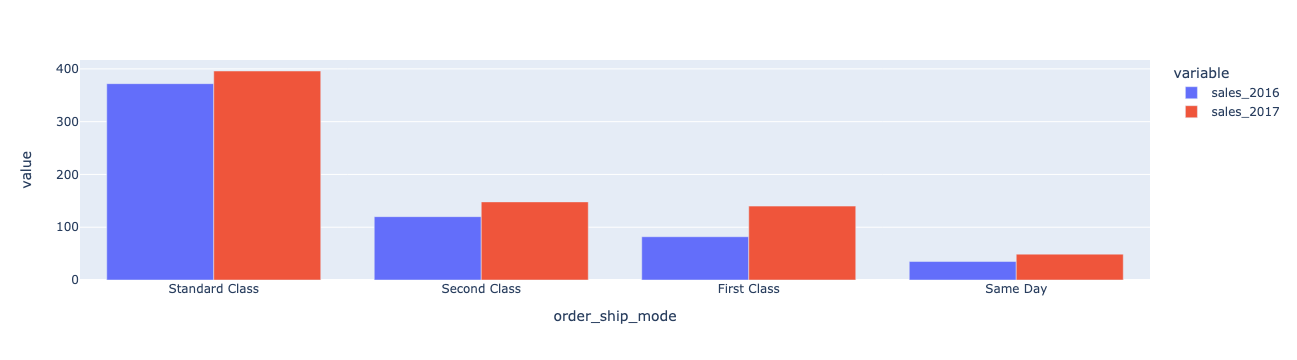

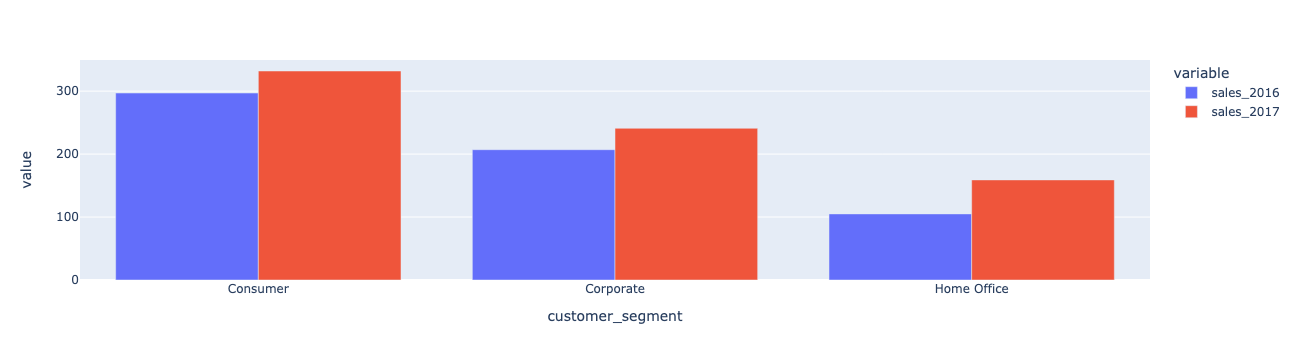

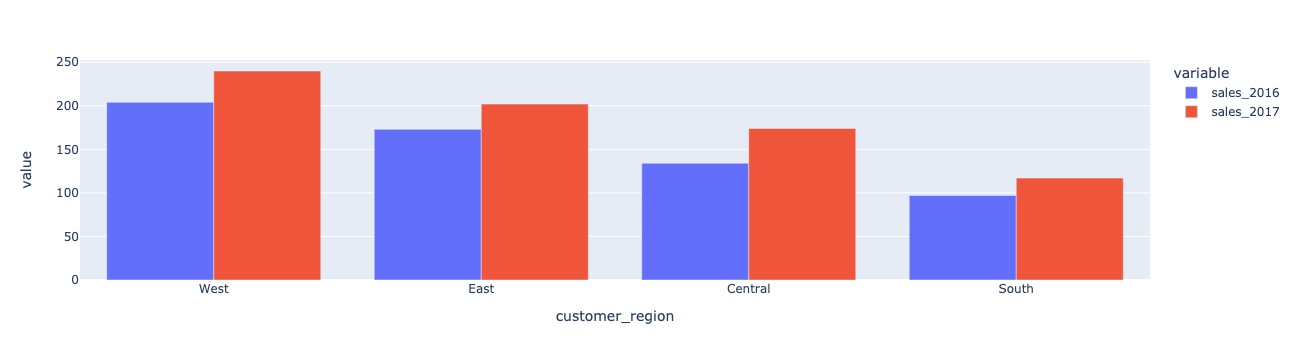

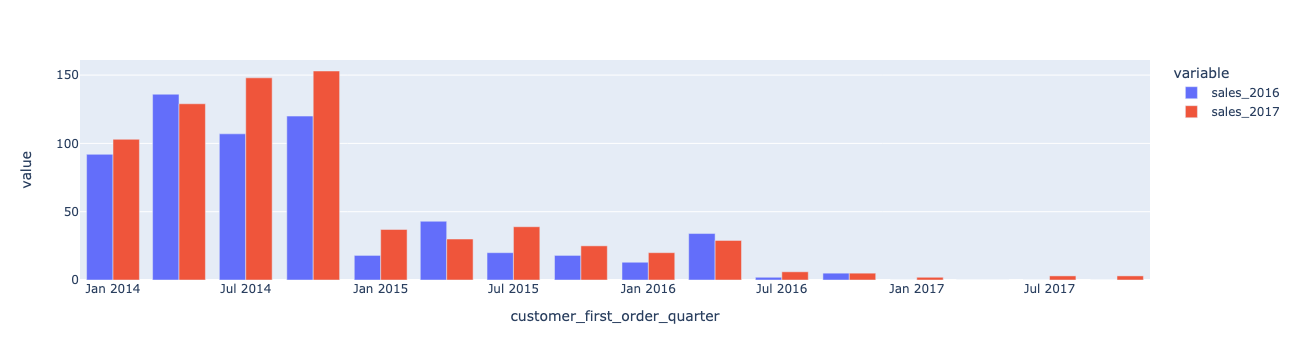

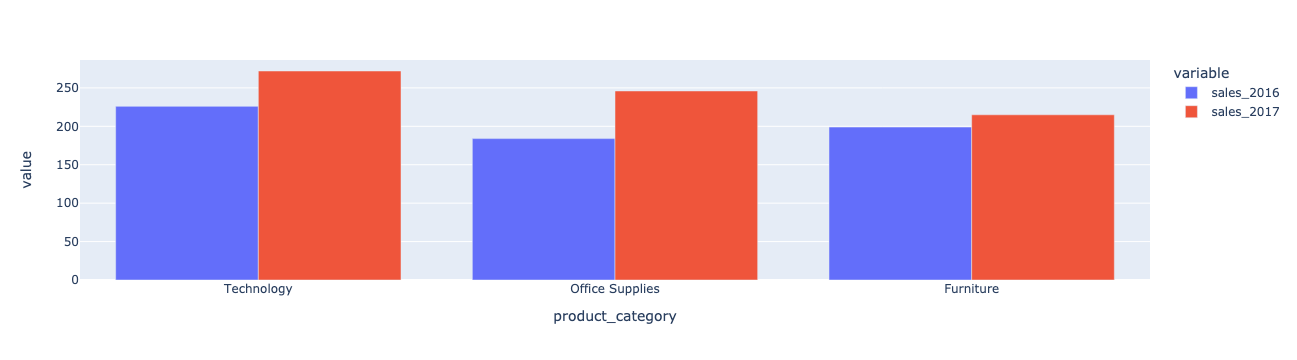

In [122]:
for dim in sales_stats.keys():
    if dim not in ('product_category, product_sub_category', 'customer_state', 'customer_country'):
        display(sales_stats[dim].plot(x=dim, y =['sales_2016','sales_2017'], kind='bar', barmode='group'))

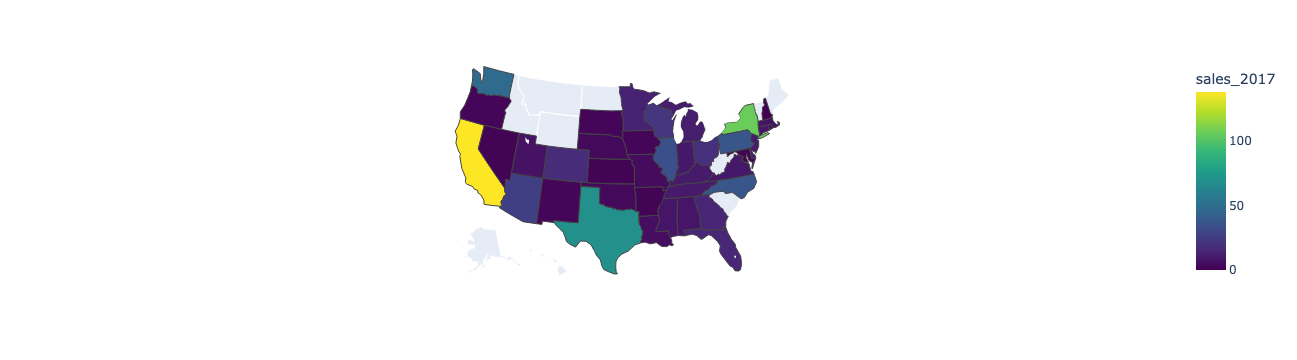

In [123]:
usa_map(
    sales_stats['customer_state'],
    'sales_2017',
)

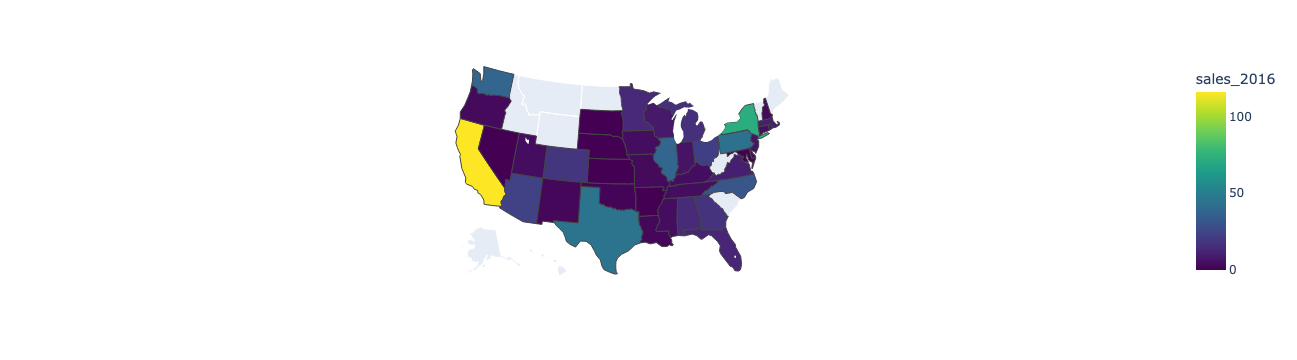

In [124]:
usa_map(
    sales_stats['customer_state'],
    'sales_2016',
)

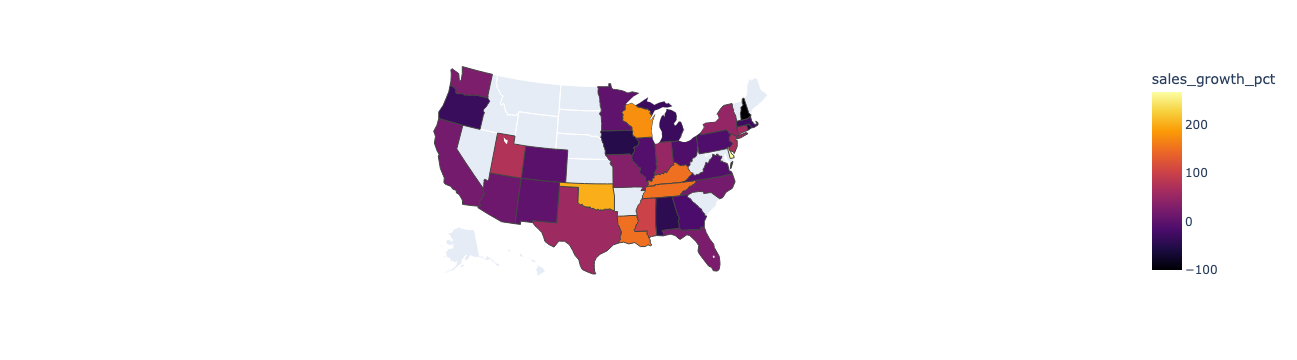

In [125]:
usa_map(
    sales_stats['customer_state'],
    'sales_growth_pct',
    'Inferno'
)

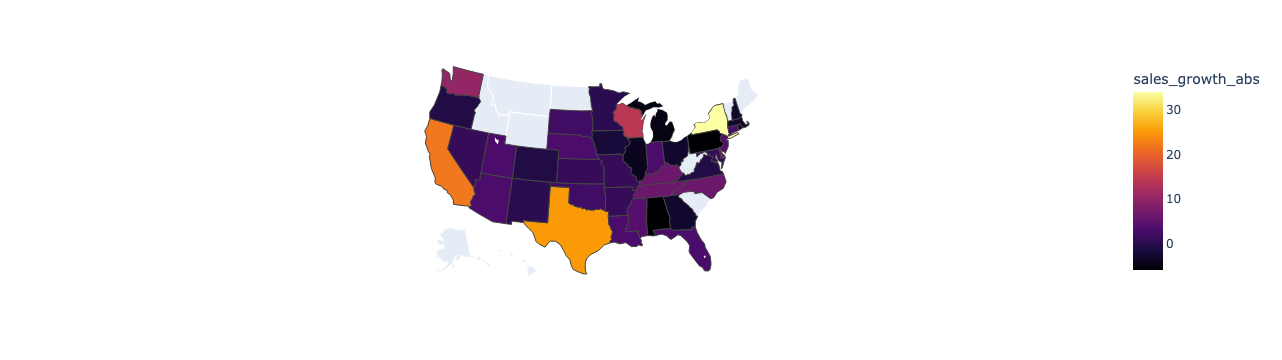

In [126]:
usa_map(
    sales_stats['customer_state'],
    'sales_growth_abs',
    'Inferno'
)

From the charts and figures we can draw the following conclusions:
* Our online store sells office equipment and furniture and related products . Technological goods bring in the most money.
* We have three client segments - Consumer, Corporate, Home Office. The average check will probably be very different from segment to segment.
* We operate in the United States. People buy from all the states, but almost half of our sales come from 3 states: California, Texas and New York.
* Most of our revenue comes from the cohorts of users who placed their first order in 2014. That's a pretty troubling symptom - we've had almost no new users for 3 years. Maybe we're doing this deliberately (e.g. advertising only at the start, in 2014), maybe not, then it's worth paying attention to
* We've seen year over year growth (2016 to 2017) in almost all dimensions: product categories, segments, delivery methods, major regions. You can see that New York and Texas have grown more than California in both absolute and relative numbers. At first glance, it seems okay, but the cohort point mentioned above is confusing. 

Now let's visualize the dynamics of sales over time with less than a year of granularity

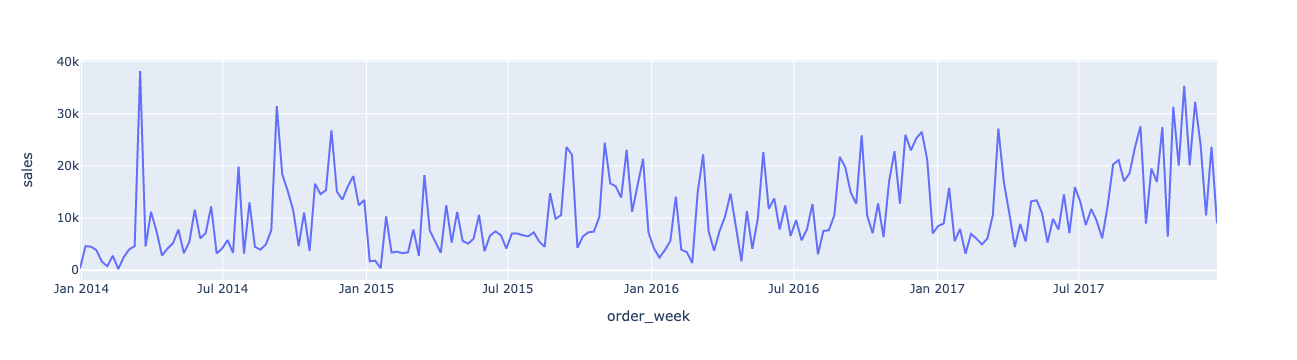

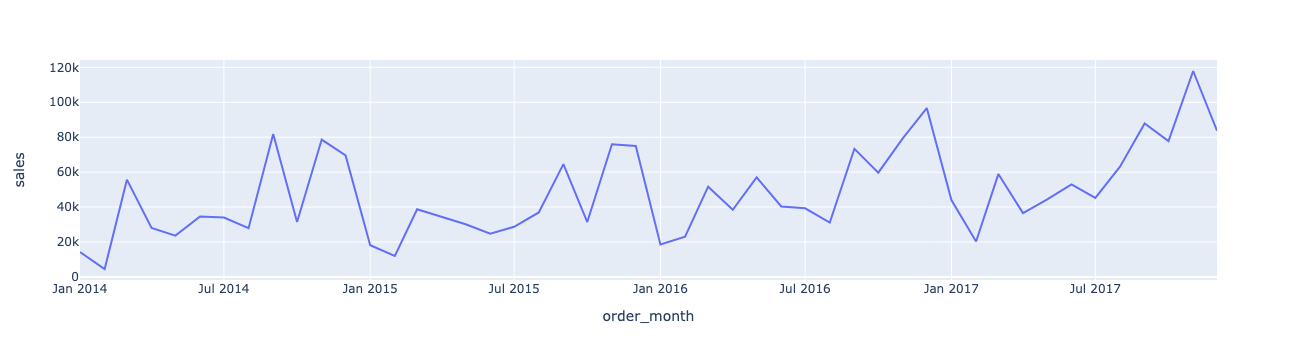

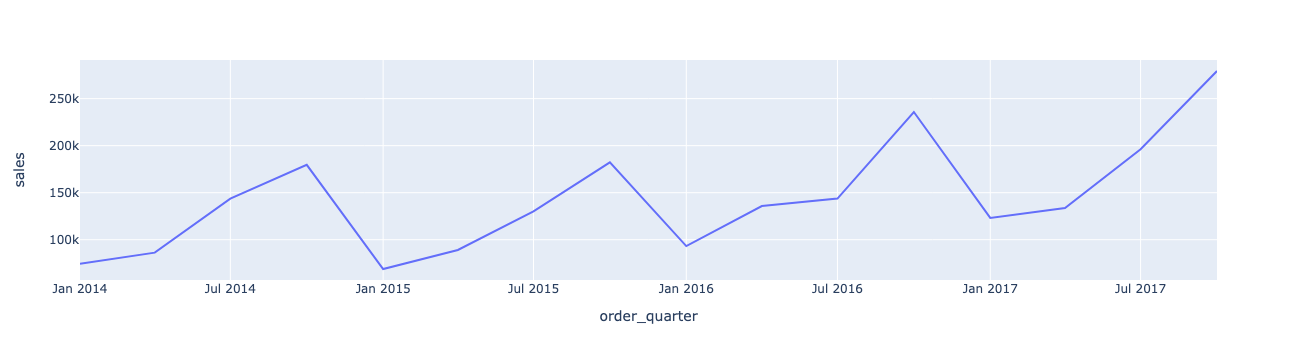

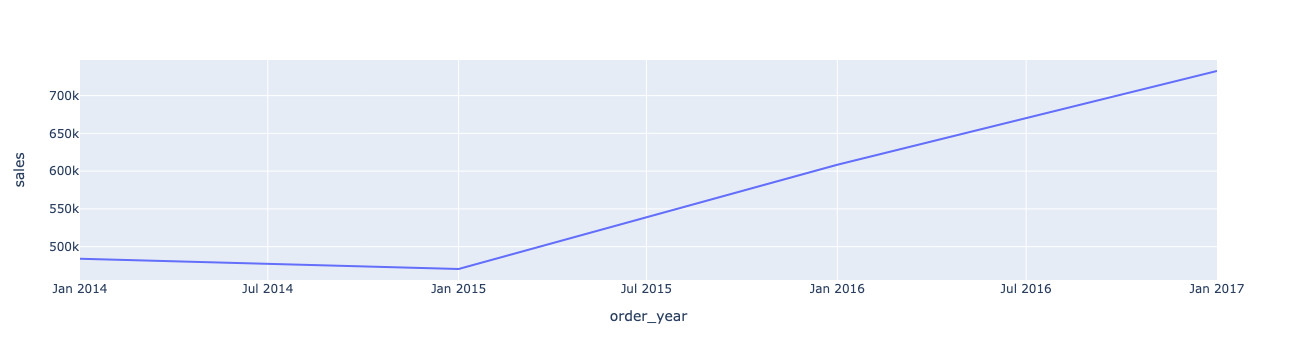

In [127]:
for p in ['week', 'month', 'quarter', 'year']:
    display(exec_sql_query("""
    SELECT
        order_{1},
        sum(product_amount) as sales
    FROM {0}
    GROUP BY
        order_{1}
    ORDER BY order_{1}
    """.format(orders_enriched_query, p)).plot(
        x='order_' + p,
        y='sales'
        )
           )

In the graphs, we see a pronounced quarterly seasonality (sales peak in Q4). We can see that we are growing year to year and quarter to quarter.

We can also see that sales in December 2017 are down compared to the same period in 2016. There was a hypothesis that the data was clipping, like December 20th, but I checked it out - the data is up to the 30th. The drop can be attributed to a record November - maybe we were able to close most of the deals early without dragging it out until the end of the year. Or maybe we made one big deal that "pulled out" a failing year. Let's try to figure it out.

Let's try to plot the revenue dynamics by our main categories. Since we are interested in the November anomaly, I chose the month as the aggregation period.

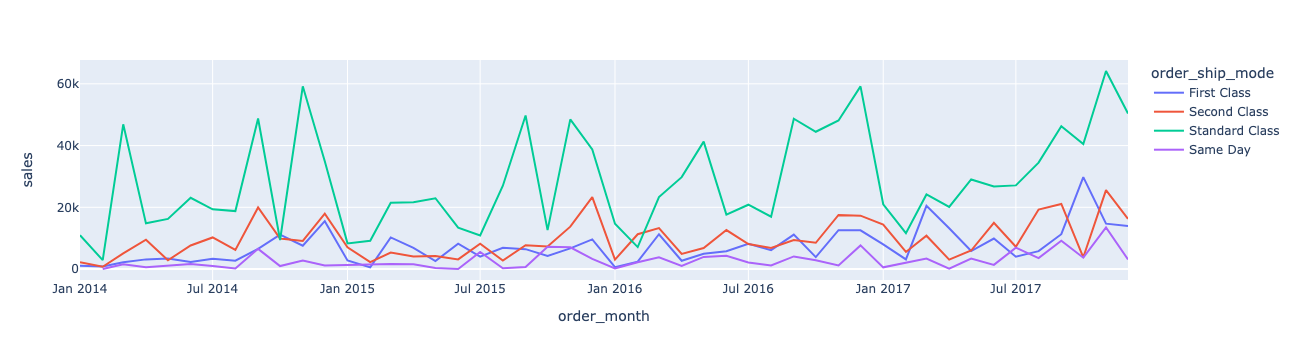

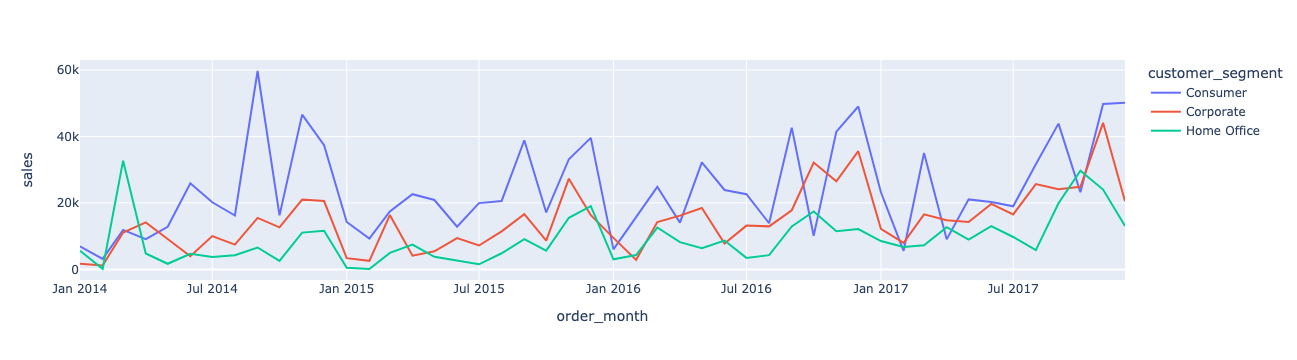

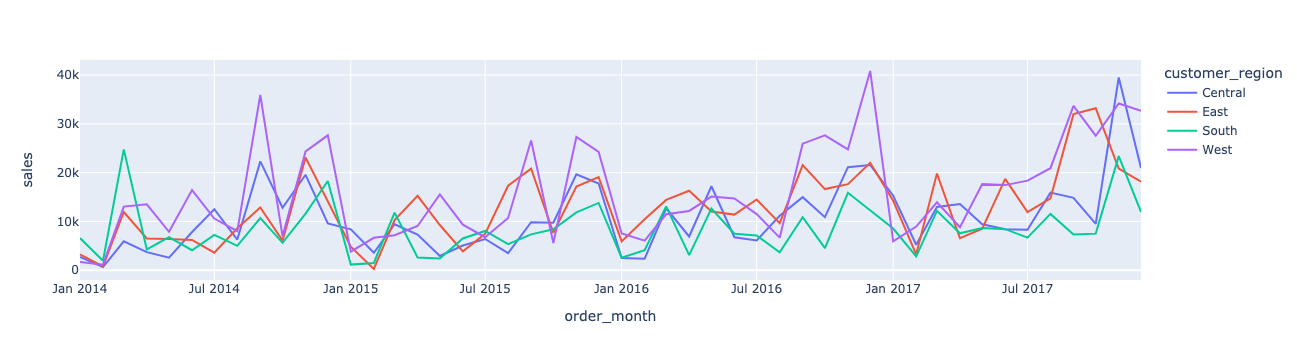

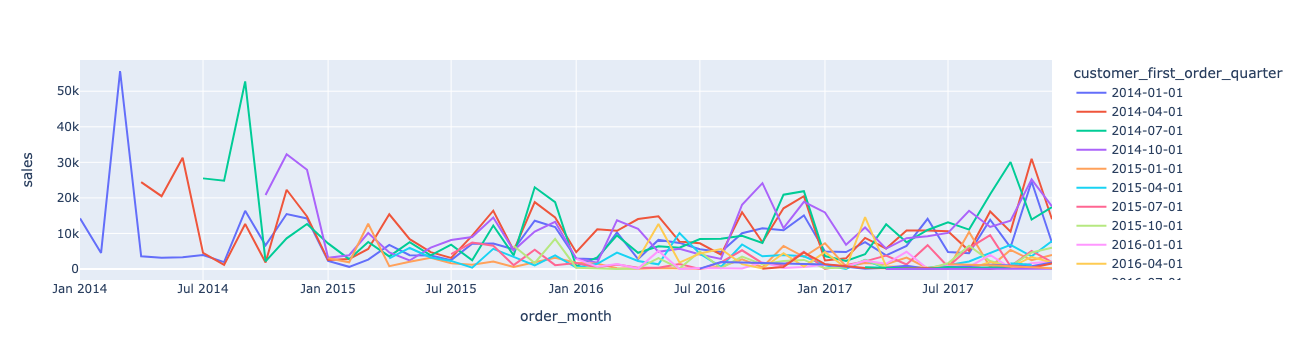

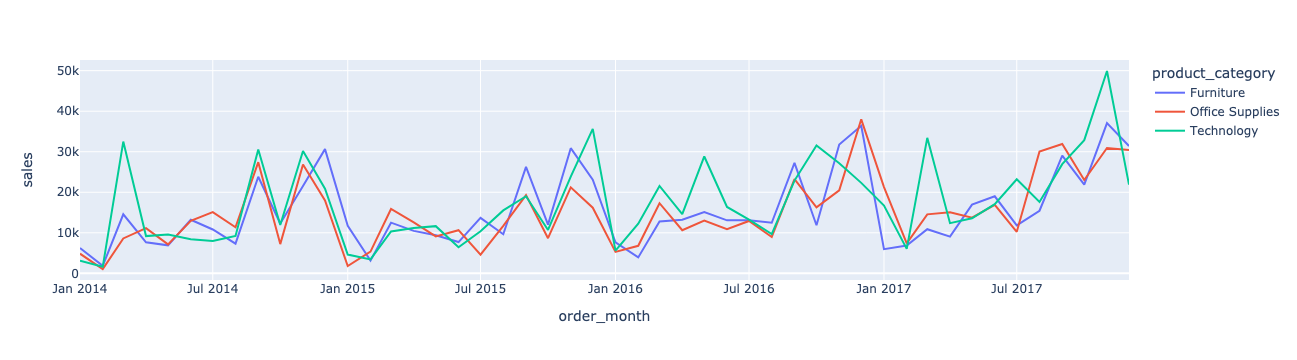

In [128]:
for dim in [
    'order_ship_mode',
    'customer_segment', 
    'customer_region',
    'customer_first_order_quarter',
    'product_category',
]:
    display(exec_sql_query("""
    SELECT
        order_month,
        CAST({1} AS TEXT) AS {1},
        sum(product_amount) as sales
    FROM {0}
    GROUP BY
        order_month, {1}
    ORDER BY order_month, {1}
    """.format(orders_enriched_query, dim)).plot(
        x='order_month',
        y='sales',
        color = dim,
        kind='line'
        )
           )

In general, sales by different slices correlate well with each other. The revenue of the 2014 cohorts is noticeable. The charts can more accurately localize the November surge: all delivery types except First Class, the Corporate segment, the Central and Southern zones, and the Technology category. The fact that the spike is visible across multiple cohorts suggests that the "fat" customer was not alone.

Now let's look at our top clients in terms of annual sales:

In [129]:
top_customers = exec_sql_query("""
SELECT 
    customer_name,
    customer_segment,
    customer_first_order_quarter,
    CAST(order_year AS TEXT) as order_year,
    sum(product_amount) as sales,
    count(distinct order_id) as orders
FROM {0}
WHERE 
    order_year>='2016-01-01'
GROUP BY 
    customer_name,
    customer_segment,
    customer_first_order_quarter,
    order_year
""".format(orders_enriched_query)
).\
    pivot_table(
        values=['sales','orders'],
        index=['customer_name','customer_segment', 'customer_first_order_quarter'],
        columns='order_year'
    ).\
    reset_index().\
    sort_values(('sales', '2017-01-01'), ascending=False)
top_customers.columns = ['-'.join(c) if c[1] != '' else c[0] for c in top_customers.columns]
top_customers['2017-01-01-cumsum']  = top_customers['sales-2017-01-01'].cumsum() / top_customers['sales-2017-01-01'].sum()
top_customers.head(20)

,customer_name,customer_segment,customer_first_order_quarter,orders-2016-01-01,orders-2017-01-01,sales-2016-01-01,sales-2017-01-01,2017-01-01-cumsum
606,Raymond Buch,Consumer,2016-04-01,3.0,3.0,914.061,14203.278,0.019388
738,Tom Ashbrook,Home Office,2014-07-01,1.0,2.0,84.272,13723.498,0.038122
326,Hunter Lopez,Consumer,2014-01-01,2.0,2.0,456.558,10522.550,0.052486
671,Seth Vernon,Consumer,2014-01-01,3.0,4.0,1041.212,8459.936,0.064034
301,Grant Thornton,Corporate,2014-04-01,NaN,1.0,NaN,8167.420,0.075183
319,Helen Wasserman,Corporate,2015-07-01,2.0,5.0,1091.580,8166.354,0.086331
737,Todd Sumrall,Corporate,2014-10-01,NaN,3.0,NaN,6702.293,0.095480
617,Rick Wilson,Corporate,2015-01-01,NaN,4.0,NaN,6193.446,0.103934
588,Pete Kriz,Consumer,2014-10-01,6.0,5.0,2001.918,5979.136,0.112096
406,Karen Ferguson,Home Office,2014-07-01,1.0,5.0,4173.812,5825.462,0.120048


Consumer
mean sales: 919.1201216066476
median sales: 520.216
mean orders: 2.4265927977839334
median orders: 2.0


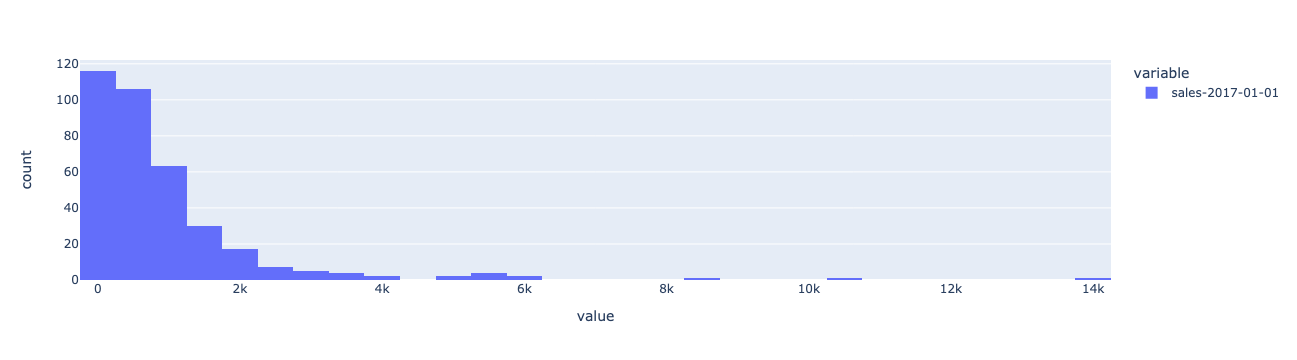

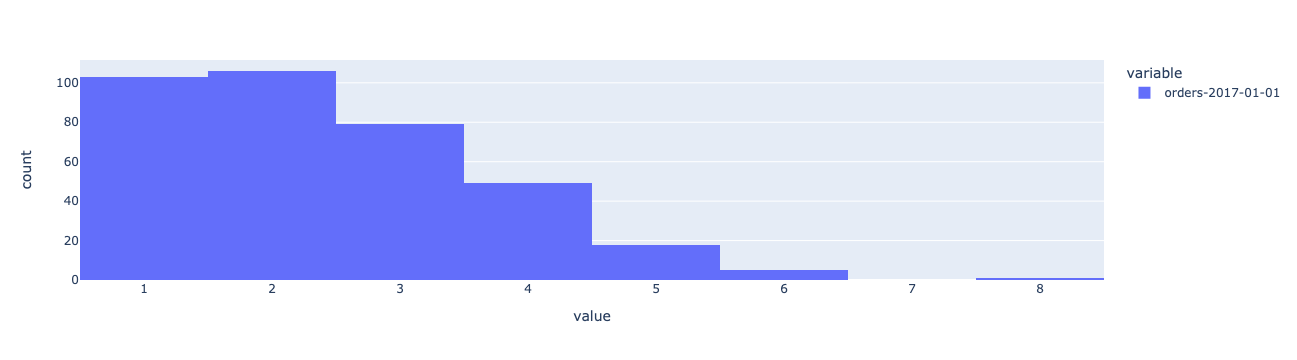

Corporate
mean sales: 1182.8600215686274
median sales: 697.8420000000001
mean orders: 2.4166666666666665
median orders: 2.0


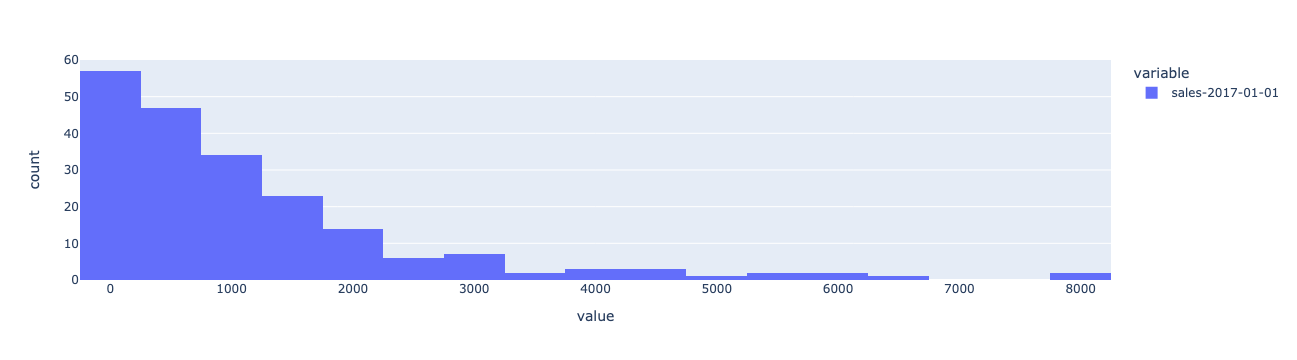

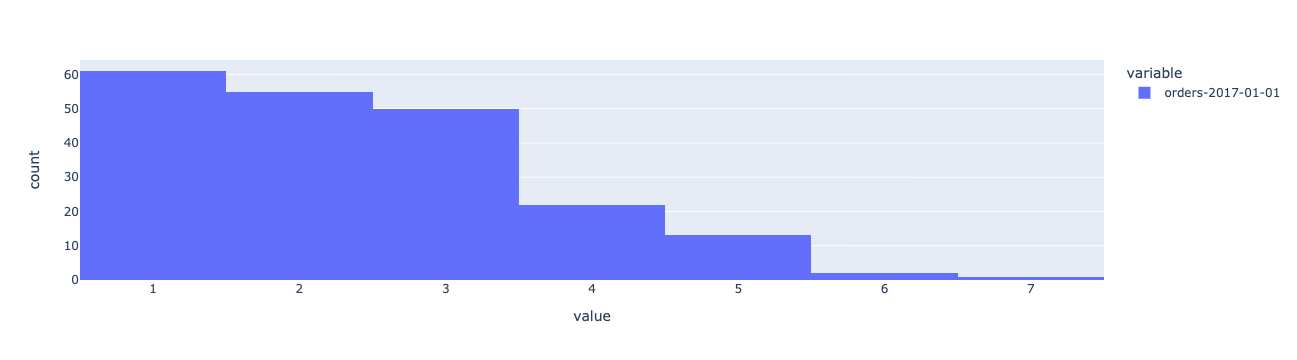

Home Office
mean sales: 1245.80258515625
median sales: 761.469
mean orders: 2.484375
median orders: 2.0


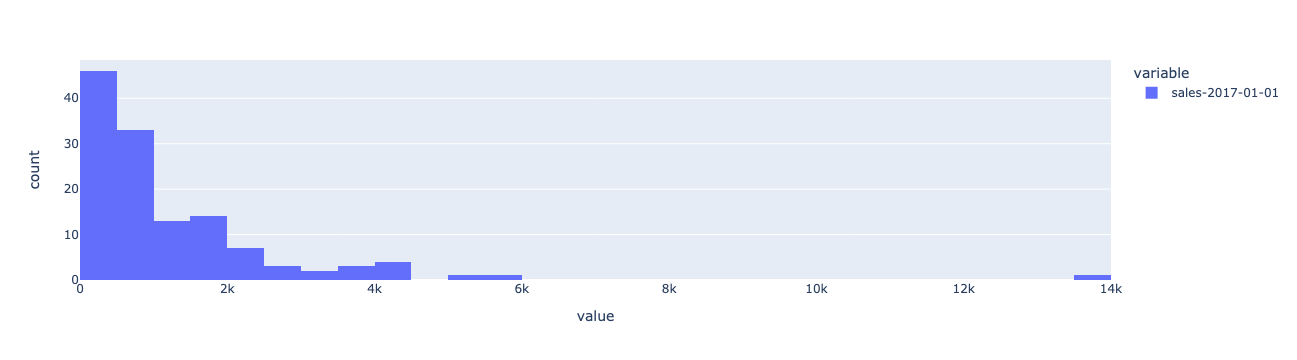

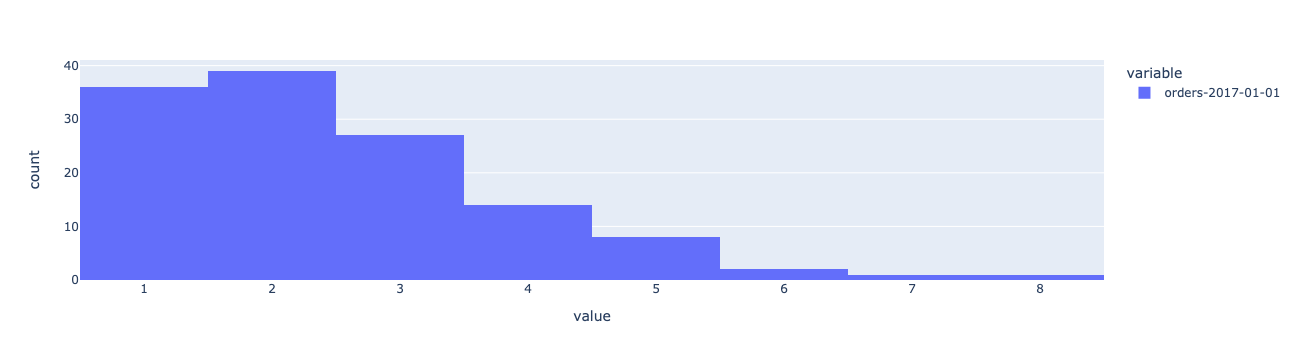

In [130]:
for cs in ['Consumer', 'Corporate', 'Home Office']:
    print(cs)
    print('mean sales:', top_customers[top_customers['customer_segment'] == cs]['sales-2017-01-01'].mean())
    print('median sales:', top_customers[top_customers['customer_segment'] == cs]['sales-2017-01-01'].median())
    print('mean orders:', top_customers[top_customers['customer_segment'] == cs]['orders-2017-01-01'].mean())
    print('median orders:', top_customers[top_customers['customer_segment'] == cs]['orders-2017-01-01'].median())
    display(top_customers[top_customers['customer_segment'] == cs]['sales-2017-01-01'].hist())
    display(top_customers[top_customers['customer_segment'] == cs]['orders-2017-01-01'].hist())

Our top 10 clients brought in about 10% of our revenue this year, and our top 100 brought in 50%. We have about 600 clients in total, so the other 50% of our sales come from the remaining 500 clients. The average check is around $400. On average, customers make 1-3 orders a year. The segments are generally similar to each other - and the shape of the distributions and averages/medians don't differ much. The largest segment in both numbers and sales is Consumer. It is interesting to see as many as 3 customers from this segment among the top 5 in terms of revenue

Let's plot the average and median bills:

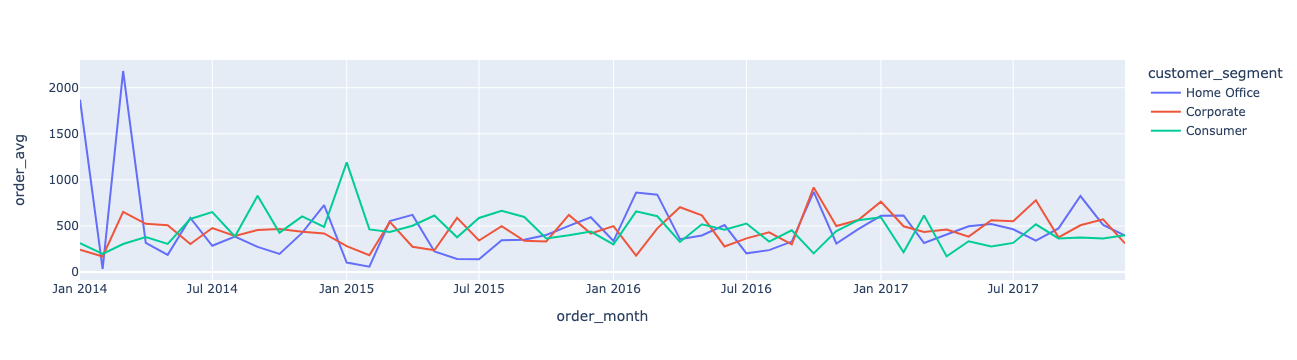

In [131]:
exec_sql_query("""
SELECT 
    order_month,
    customer_segment,
    avg(sales) as order_avg
    --median(sales) as order_median
FROM (
SELECT 
    order_month,
    order_id,
    customer_segment,
    sum(product_amount) as sales
FROM {}
GROUP BY 
    order_month,
    order_id,
    customer_segment
) as orders
GROUP BY order_month, customer_segment
ORDER BY order_month
""".format(orders_enriched_query)).plot(
    x='order_month',
    y='order_avg',
    color='customer_segment'
)

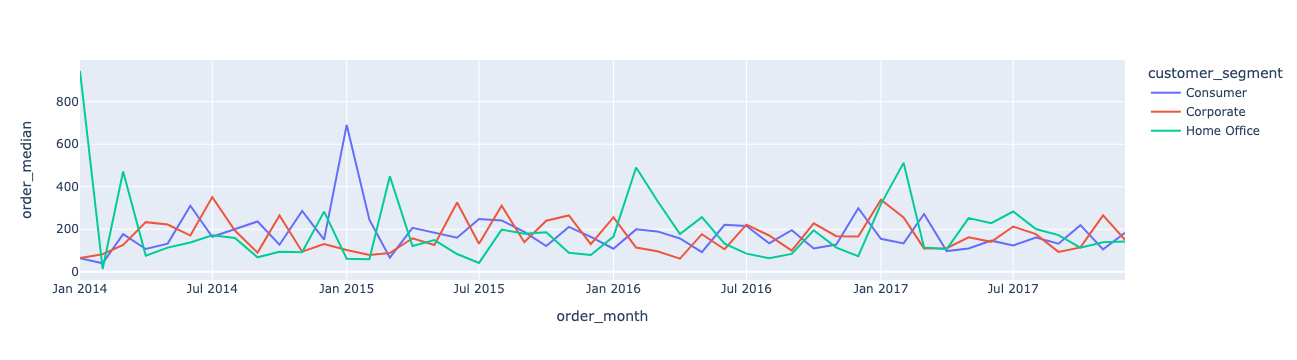

In [132]:
exec_sql_query("""

SELECT 
    order_month,
    order_id,
    customer_segment,
    sum(product_amount) as sales
FROM {}
GROUP BY 
    order_month,
    order_id,
    customer_segment
""".format(orders_enriched_query)).\
    groupby(['order_month', 'customer_segment'], as_index=False).\
    agg({'sales':'median'}).\
    rename({'sales':'order_median'}, axis=1).\
plot(
    x='order_month',
    y='order_median',
    color='customer_segment'
)

The graphs show that the average check is relatively stable, does not vary greatly from segment to segment and fluctuates around $300-500.

According to the data above, we can answer the questions of the assignment:

1. **Are store sales up or down?** Sales are up year over year and quarter over quarter. The drop in December 2017 compared to December 2016 can be explained by a "strong" November (perhaps some of the deals were closed early in the end of the quarter?).

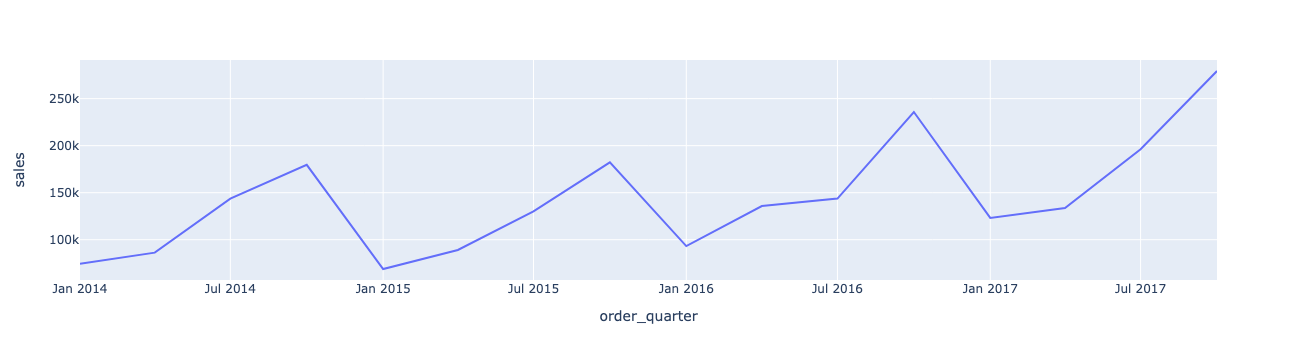

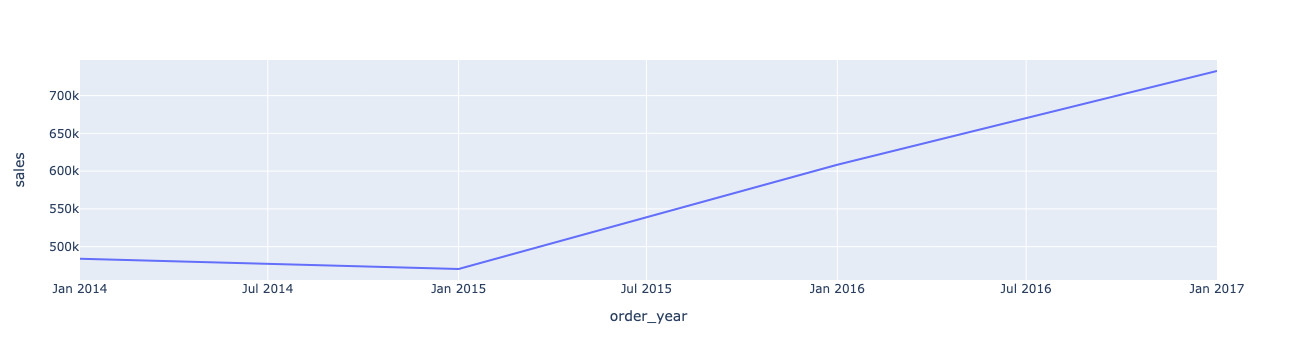

In [133]:
for p in ['quarter', 'year']:
    display(exec_sql_query("""
    SELECT
        order_{1},
        sum(product_amount) as sales
    FROM {0}
    GROUP BY
        order_{1}
    ORDER BY order_{1}
    """.format(orders_enriched_query, p)).plot(
        x='order_' + p,
        y='sales'
        )
           )

2. **How does the average check change?** The average check is relatively stable, does not vary much from segment to segment and fluctuates around $300-500

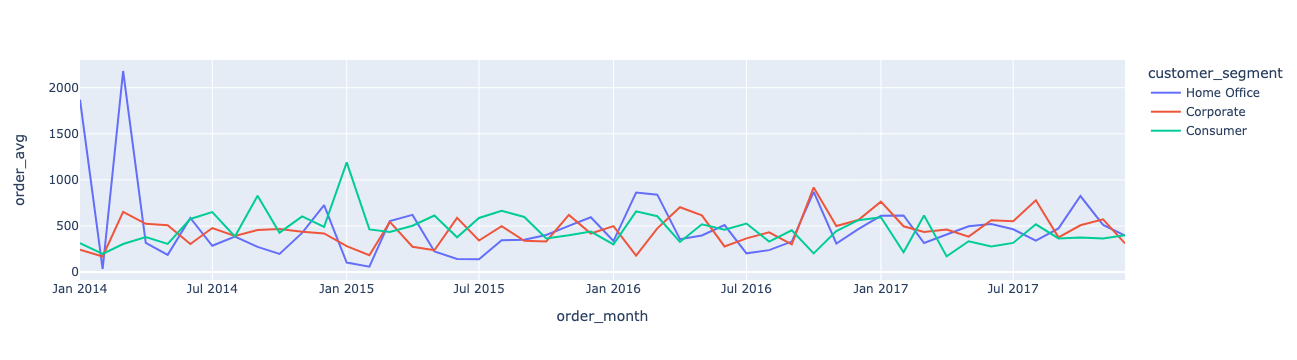

In [134]:
exec_sql_query("""
SELECT 
    order_month,
    customer_segment,
    avg(sales) as order_avg
    --median(sales) as order_median
FROM (
SELECT 
    order_month,
    order_id,
    customer_segment,
    sum(product_amount) as sales
FROM {}
GROUP BY 
    order_month,
    order_id,
    customer_segment
) as orders
GROUP BY order_month, customer_segment
ORDER BY order_month
""".format(orders_enriched_query)).plot(
    x='order_month',
    y='order_avg',
    color='customer_segment'
)

3. **Which product categories and subcategories brought in the most revenue?** Top 5:

In [135]:
sales_stats['product_category, product_sub_category'].iloc[:,:3].head()

,product_category,product_sub_category,sales_total
0,Technology,Phones,330.0
1,Furniture,Chairs,328.0
2,Office Supplies,Binders,203.0
3,Office Supplies,Storage,223.0
4,Technology,Copiers,150.0


4. **Explain the sales dynamics of the last 3 months. What factors had the strongest impact on revenue?**
I would interpret this question as "Investigate, a spike in revenue in November."
Let's look at the top customers by revenue for November:

In [136]:
top_customers_q4_2017 = exec_sql_query("""
SELECT 
    customer_name,
    customer_segment,
    customer_first_order_quarter,
    CAST(order_month AS TEXT) as order_month,
    sum(product_amount) as sales,
    count(distinct order_id) as orders
FROM {0}
WHERE 
    order_month>='2017-10-01'
GROUP BY 
    customer_name,
    customer_segment,
    customer_first_order_quarter,
    order_month
""".format(orders_enriched_query)
).\
    pivot_table(
        values=['sales','orders'],
        index=['customer_name','customer_segment', 'customer_first_order_quarter'],
        columns='order_month'
    ).\
    reset_index().\
    sort_values(('sales', '2017-11-01'), ascending=False)
top_customers_q4_2017.columns = ['-'.join(c) if c[1] != '' else c[0] for c in top_customers_q4_2017.columns]
# top_customers_q4_2017['2017-01-01-cumsum']  = top_customers_q4_2017['sales-2017-01-01'].cumsum() / top_customers_q4_2017['sales-2017-01-01'].sum()
top_customers_q4_2017.head(20)

,customer_name,customer_segment,customer_first_order_quarter,orders-2017-10-01,orders-2017-11-01,orders-2017-12-01,sales-2017-10-01,sales-2017-11-01,sales-2017-12-01
192,Hunter Lopez,Consumer,2014-01-01,1.0,1.0,NaN,22.580,10499.970,NaN
174,Grant Thornton,Corporate,2014-04-01,NaN,1.0,NaN,NaN,8167.420,NaN
410,Ted Trevino,Consumer,2014-04-01,NaN,2.0,NaN,NaN,3813.166,NaN
364,Ross Baird,Home Office,2014-04-01,1.0,1.0,NaN,63.824,3629.936,NaN
413,Thomas Boland,Corporate,2014-10-01,NaN,1.0,NaN,NaN,3291.070,NaN
418,Tonja Turnell,Home Office,2015-10-01,NaN,1.0,1.0,NaN,3083.940,5.76
2,Adam Bellavance,Home Office,2015-07-01,NaN,2.0,NaN,NaN,2835.538,NaN
382,Sarah Foster,Consumer,2014-10-01,NaN,1.0,NaN,NaN,2690.740,NaN
63,Brian Moss,Corporate,2014-07-01,NaN,3.0,NaN,NaN,2661.894,NaN
230,Justin Deggeller,Corporate,2014-10-01,NaN,1.0,NaN,NaN,2521.480,NaN


We see two big orders - from Hunter Lopez and Grant Thornton. Most likely they were the reason for the surge. Let's see what they bought and make sure their regions, segments, cohorts and product categories match the emissions we noticed in the revenue charts above.

In [137]:
exec_sql_query("""
SELECT order_id, order_date, customer_id, customer_name, customer_region, customer_segment, product_id, product_name, product_category, product_quantity, product_amount
FROM {}
WHERE 
    customer_name in ('Hunter Lopez', 'Grant Thornton', 'Ted Trevino')
    AND order_month = '2017-11-01'
ORDER BY product_amount DESC
""".format(orders_enriched_query))

,order_id,order_date,customer_id,customer_name,customer_region,customer_segment,product_id,product_name,product_category,product_quantity,product_amount
0,CA-2017-166709,2017-11-17,HL-15040,Hunter Lopez,Central,Consumer,TEC-CO-10004722,Canon imageCLASS 2200 Advanced Copier,Technology,3,10499.970
1,US-2017-168116,2017-11-04,GT-14635,Grant Thornton,South,Corporate,TEC-MA-10004125,Cubify CubeX 3D Printer Triple Head Print,Technology,4,7999.980
2,CA-2017-122490,2017-11-13,TT-21070,Ted Trevino,West,Consumer,FUR-CH-10001215,Global Troy Executive Leather Low-Back Tilter,Furniture,6,2404.704
3,CA-2017-122490,2017-11-13,TT-21070,Ted Trevino,West,Consumer,OFF-BI-10001718,GBC DocuBind P50 Personal Binding Machine,Office Supplies,11,563.024
4,CA-2017-108035,2017-11-29,TT-21070,Ted Trevino,West,Consumer,FUR-CH-10000454,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",Furniture,2,390.368
5,CA-2017-122490,2017-11-13,TT-21070,Ted Trevino,West,Consumer,OFF-ST-10000991,Space Solutions HD Industrial Steel Shelving.,Office Supplies,3,344.910
6,US-2017-168116,2017-11-04,GT-14635,Grant Thornton,South,Corporate,OFF-AP-10002457,Eureka The Boss Plus 12-Amp Hard Box Upright V...,Office Supplies,2,167.440
7,CA-2017-108035,2017-11-29,TT-21070,Ted Trevino,West,Consumer,FUR-FU-10004017,Tenex Contemporary Contur Chairmats for Low an...,Furniture,5,101.520
8,CA-2017-122490,2017-11-13,TT-21070,Ted Trevino,West,Consumer,OFF-LA-10001613,Avery File Folder Labels,Office Supplies,3,8.640


Everything seems to be true.